In [2]:
import nltk
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# makes inline plots to have better quality
%config InlineBackend.figure_format = 'svg'
import itertools
import re

In [3]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

### Reading the reviews from "reviews_imdb.txt" and labels from "labels.txt"

In [4]:
def getLines(inFile):
    fr = open(inFile,'r') 
    myList=[]
    for line in fr :
        myList.append(line.strip())
    fr.close()
    return myList

In [5]:
reviewList=getLines("reviews_imdb.txt")
labelList=getLines ("labels.txt")

### Data preprocessing

In [6]:
def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", r.lower()) for r in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", r) for r in reviews]
    return reviews

In [7]:
reviews_clean = preprocess_reviews(reviewList)

In [8]:
tokenized_reviews = [nltk.word_tokenize(review) for review in reviews_clean] # tokenization of reviewList

### Most frequent words

In [9]:
# extraction of words in positive reviews
pos_words = [tokenized_reviews[i] for i in range(len(tokenized_reviews)) if labelList[i] == 'positive']
pos_words = list(itertools.chain.from_iterable(pos_words))

In [10]:
# extraction of words in negative reviews
neg_words = [tokenized_reviews[i] for i in range(len(tokenized_reviews)) if labelList[i] == 'negative']
neg_words = list(itertools.chain.from_iterable(neg_words))

In [11]:
# stop words removing
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.add('movie')
stop_words.add('film')
stop_words.add('character')
stop_words.add('characters')
stop_words.add('br')
pos_remained = [word for word in pos_words if word not in stop_words]
neg_remained = [word for word in neg_words if word not in stop_words]

In [12]:
# computing frequency distributions of words in poistive and negative reviews (without stop words)
fd_pos = nltk.FreqDist(p for p in pos_remained)
fd_neg = nltk.FreqDist(n for n in neg_remained)

In [13]:
most_common_pos = fd_pos.most_common(60) #60 most common words in positive reviews
most_common_neg = fd_neg.most_common(60) #60 most common words in negative reviews

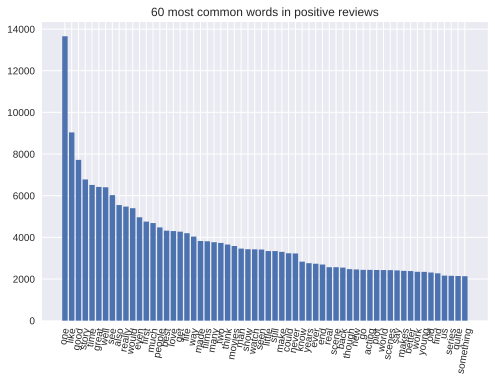

In [14]:
plt.bar(range(len(most_common_pos)), [val[1] for val in most_common_pos])
plt.xticks(range(len(most_common_pos)), [val[0] for val in most_common_pos])
plt.xticks(rotation=80)
plt.title('60 most common words in positive reviews')
plt.show()

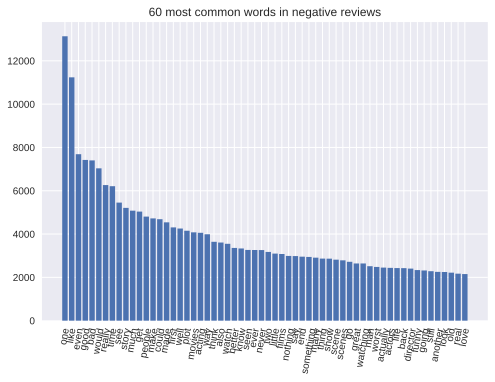

In [15]:
plt.bar(range(len(most_common_neg)), [val[1] for val in most_common_neg])
plt.xticks(range(len(most_common_neg)), [val[0] for val in most_common_neg])
plt.xticks(rotation=80)
plt.title('60 most common words in negative reviews')
plt.show()

In [16]:
# intersection of positive and negative words
inter = list(set(pos_remained).intersection(set(neg_remained)))

In [17]:
inter[:10]

['ghajini',
 'respectability',
 'sledge',
 'rosy',
 'pacino',
 'ballgame',
 'grover',
 'maxim',
 'hyman',
 'tamara']

### Preprocessing again

In [18]:
positive_list = ['like','good','great']
negative_list = ['bad','worst']

In [19]:
#removing stop words from tokenized reviews. 
#'like','good','great' in positive reviews only
#'bad','worst' in negative reviews only
tokenized_clean = []
for i in range(len(tokenized_reviews)):
    review = []
    for j in tokenized_reviews[i]:
        if labelList[i] == 'positive':
            if j not in stop_words and j not in negative_list:
                review.append(j)
        else:
            if j not in stop_words and j not in positive_list:
                review.append(j)
    tokenized_clean.append(review)           

In [20]:
reviews = [' '.join(t) for t in tokenized_clean] #reviews for training

In [21]:
reviews[1]

'story man unnatural feelings pig starts opening scene terrific example absurd comedy formal orchestra audience turned insane violent mob crazy chantings singers unfortunately stays absurd whole time general narrative eventually making putting even era turned cryptic dialogue would make shakespeare seem easy third grader technical level better might think cinematography future vilmos zsigmond future stars sally kirkland frederic forrest seen briefly'

In [22]:
labels = [1 if w == 'positive' else 0 for w in labelList] #labels for training

## Feedforward neural network + CountVectorizer

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [24]:
# Convert a collection of text documents to a matrix of token counts
def encoder(X_train,X_test):
    cv = CountVectorizer()
    cv.fit(X_train)
    return cv.transform(X_train), cv.transform(X_test)

In [25]:
train_X, test_X, train_y, test_y = train_test_split(reviews, labels, test_size=0.3, random_state=10)

In [26]:
X_train, X_test = encoder(train_X, test_X) #encoding of train and test reviews

In [27]:
y_train = torch.from_numpy(np.array(train_y)).type(torch.LongTensor) 

In [28]:
y_test = torch.from_numpy(np.array(test_y)).type(torch.LongTensor)

In [29]:
#Place a tensor on GPU (for speed)
device = torch.device('cpu')

In [30]:
# Transforms sparse matrix to tensor
def matrix_to_tensor(X):
    coo = X.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [31]:
train_X_tensor = matrix_to_tensor(X_train)

In [32]:
test_X_tensor = matrix_to_tensor(X_test)

In [33]:
train_X_tensor.shape

torch.Size([17500, 64149])

#### Neural network architecture

In [34]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,num_classes = 2,hidden_size1 = 500,hidden_size2 = 100):
        super(NeuralNet, self).__init__()
     
        self.fc1 = nn.Linear(input_size,hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1,hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2,num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [35]:
def train(model,X,y,optimizer,loss_fn=nn.CrossEntropyLoss(),n_epoches = 10,print_loss = True):
    for t in range(n_epoches):
        model.zero_grad()
        optimizer.zero_grad()
      # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(X)
      # Compute Loss.
        loss = loss_fn(y_pred, y)
        if print_loss:
            print(t, loss.item())
      # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
      # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

In [36]:
def predict(model,X):
    outputs = model(X)
    return torch.max(outputs, 1)[1]

### training and prediction

In [37]:
net = NeuralNet(train_X_tensor.shape[1])
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [38]:
train(net,train_X_tensor,y_train,optimizer,n_epoches=20)

0 0.693261444568634
1 0.6875587105751038
2 0.6751181483268738
3 0.6574298143386841
4 0.6352834701538086
5 0.6087809205055237
6 0.578775942325592
7 0.5477508306503296
8 0.5171235203742981
9 0.48765239119529724
10 0.46033796668052673
11 0.43612098693847656
12 0.4151201546192169
13 0.3972803056240082
14 0.3823647201061249
15 0.3700200915336609
16 0.3599091172218323
17 0.3517014980316162
18 0.34504422545433044
19 0.33963853120803833


In [39]:
y_pred = predict(net,test_X_tensor)

In [40]:
print('Test accuracy: ', accuracy_score(y_test,y_pred))

Test accuracy:  0.9157333333333333


## Feedforward neural network + Pretrained word embeddings

In [41]:
import pickle
import bcolz
from keras.preprocessing.sequence import pad_sequences
from keras.utils import *
from torch.utils import data

Using TensorFlow backend.


In [42]:
# extracting vocabulary from preprocessed rewievs
full_vocabulary = set()
for review in tokenized_clean:
    for word in review:
        full_vocabulary.add(word)

In [43]:
vocab_size = len(full_vocabulary) 

In [44]:
# constracting 'word to index' dictionary
idx = 0
word_to_idx = {} #dictionary word:number
for word in full_vocabulary:
    word_to_idx[word] = idx
    idx += 1

In [45]:
#constructing 'index to word dictionary'
idx_to_word = {value: key for key, value in iter(word_to_idx.items())} #dictionary number:word

In [46]:
#creating list of sequences, which are lists of indexes, for every review
sequence_reviews = []
for review in tokenized_clean:
    word_seq = []
    for word in review:
        word_seq.append(word_to_idx[word])
    sequence_reviews.append(word_seq)

In [47]:
# loading glove word embeddings from file
name = "glove.6B.100d.txt"
with open(name, 'r', encoding="utf8") as f: 
    lines = [line.split() for line in f] 

In [48]:
#setting up main arrays
glove_words = [elem[0] for elem in lines]
glove_words_idx = {elem:idx for idx,elem in enumerate(glove_words)} #is elem:idx equal to glove_words_idx[elem]=idx?
glove_vecs = np.stack(np.array(elem[1:], dtype=np.float32) for elem in lines) #np.float32 -standard double-precision floating point

In [49]:
emb_dim = glove_vecs.shape[1] #embedding dimension

In [50]:
emb = np.zeros((vocab_size, emb_dim)) #create an array of zeros 

In [51]:
#mapping words vectors from Glove to IMDb words
for num in range(1, len(emb)):
    word = idx_to_word[num]
    if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and word in glove_words_idx.keys(): 
        temp_idx = glove_words_idx[word] #getting index of word in Glove dictionary
        emb[num] = glove_vecs[temp_idx] 
    else: #if no match identified (if we can't find a match in Glove, will just assign to random value)
        emb[num] = np.random.normal(scale=0.6, size=(emb_dim,)) 

In [52]:
# summing up embedding vectors for every review and store it in train_set
train_set = []
for review in sequence_reviews:
    word_sum = np.zeros(emb_dim)
    for idx in review:
        word_sum += emb[idx]
    train_set.append(word_sum)

In [53]:
#train test split
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(train_set, labels, test_size=0.3, random_state=10)

#creating tensors
y_train_emb = torch.from_numpy(np.array(y_train_emb))
y_test_emb = torch.from_numpy(np.array(y_test_emb))

#creating tensors
X_train_emb = torch.tensor(X_train_emb, dtype = torch.float)
X_test_emb = torch.tensor(X_test_emb, dtype = torch.float)

### training and prediction

In [62]:
net_emb = NeuralNet(X_train_emb.shape[1],hidden_size1 = 500,hidden_size2 = 100)
learning_rate = 0.001
optimizer = torch.optim.Adam(net_emb.parameters(), lr=learning_rate)

In [63]:
train(net_emb,X_train_emb,y_train_emb,optimizer,n_epoches=300,print_loss=False)

In [64]:
y_pred_emb = predict(net_emb,X_test_emb)

In [65]:
print('Test accuracy: ', accuracy_score(y_test_emb,y_pred_emb)) #accuracy with embedding dimension = 100

Test accuracy:  0.8276
